In [177]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from scipy.stats import norm
import pdb
import matplotlib.pyplot as plt 
import scipy.stats
from tqdm import tqdm

np.random.seed(123)
# creating black scholes price and greeks
class BS():
    
    def CallPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return S*norm.cdf(dp) - K*np.exp(-r*T)*norm.cdf(dm)
    
    def PutPrice(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        
        return K*np.exp(-r*T)*norm.cdf(-dm) - S*norm.cdf(-dp)
    
    
    def CallDelta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/(np.sqrt(T)*sigma)
        return norm.cdf(dp)
    
    def PutDelta(S, T, K, sigma, r):
        
        return BS.CallDelta(S, T, K, sigma, r)-1
    
    def CallGamma(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.pdf(dp)/(S*sigma*np.sqrt(T))
    
    def PutGamma(S, T, K, sigma, r):
        
        return BS.CallGamma(S, T, K, sigma, r)
    
    def CallVega(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return norm.pdf(dp)*S*np.sqrt(T)
    
    def CallTheta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return -S*norm.pdf(dp)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(dm)
    
    def PutTheta(S, T, K, sigma, r):
        
        dp = (np.log(S/K) + (r+0.5*sigma**2)*T)/np.sqrt(T)/sigma
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return -S*norm.pdf(dp)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-dm)
    
    def CallRho(S, T, K, sigma, r):
        
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return K*T*np.exp(-r*T)*norm.pdf(dm)
    
    def PutRho(S, T, K, sigma, r):
        
        dm = (np.log(S/K) + (r-0.5*sigma**2)*T)/np.sqrt(T)/sigma
        
        return -K*T*np.exp(-r*T)*norm.pdf(-dm)    

In [178]:
# get s
def get_dS(dt, mu, sigma, S_last):
    std = np.sqrt(dt)
    z = np.random.normal(0, std,1)[0]
    return mu * S_last * dt + sigma * S_last * z

# get m
def get_M(M_last, r, dt, delta, delta_last, S, phi_equity):
    return M_last * np.exp(r * dt) - (delta - delta_last) * S - phi_equity * np.abs(delta - delta_last)

In [179]:
# Set up
S0 = 100
K = 100
sigma = 0.2
mu = 0.1
r = 0.02
T = 1/4 * 1 # 1/4 of a year

phi_equity = 0.005
phi_option = 0.01

P0 = BS.PutPrice(S0, T, K, sigma, r)
delta0 = BS.PutDelta(S0,T,K,sigma,r)
M0 = P0 - delta0 * S0 - phi_equity * np.abs(delta0) - phi_option
band = 0.1
band_width = band/2

dt = 1/365 # day is the smallest interval
Ndt = int(T*365) # number of days in 1/4 year
t_list = np.linspace(0,T, int(round(Ndt,0))+1)[1:]

print(len(t_list))

list_M_final = []

91


In [180]:
check_s = lambda s: s < K

In [181]:
for sim in tqdm(range(1000)):
    s_init = S0
    delta_init = delta0 # negative position
    M_init = M0
    delta_center = delta_init
    ub = -0.01
    lb = -0.99
    upper_band = delta0 + 0.05
    lower_band = delta0 - 0.05
    
    for day in t_list:
        stock_price = s_init + get_dS(dt, mu, sigma, s_init)
        delta = BS.PutDelta(stock_price, T-day, K, sigma, r)
        if stock_price <= 0: # check if stock price is below 0
            stock_price = s_init
        
        if delta_init >= ub:
            upper_band = 0
            lower_band = -0.01
        elif delta_init <= lb:
            upper_band = -0.99
            lower_band = -1

        if delta > lower_band and delta < upper_band:
            money_account = M_init * np.exp(r * dt)
        else:
            money_account = get_M(M_init, r, dt, delta, delta_center, stock_price, phi_equity)
            delta_center = delta
        
        delta_init = delta
        s_init = stock_price
        M_init = money_account
    

    # physical settling
    money_account -= (stock_price < K) * K
    # financial settling
    # Final_M = M_init * np.exp(r*dt) + delta * Final_S - phi_equity * np.abs(delta) 

    list_M_final.append(money_account)

100%|██████████| 1000/1000 [00:04<00:00, 231.02it/s]


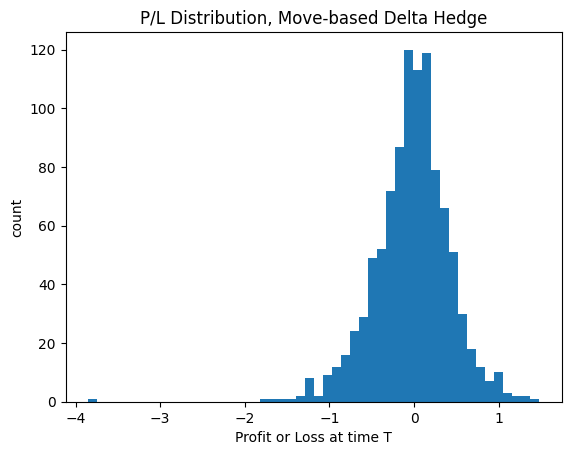

In [182]:
plt.hist(list_M_final,50)
plt.xlabel('Profit or Loss at time T')
plt.ylabel('count')
plt.title('P/L Distribution, Move-based Delta Hedge')
plt.savefig('Profit Distribition, Move-based Delta Hedge.png')

In [183]:
# Calculate CVaR
M_final = np.array(list_M_final)
confidence = 10
mean_hedge = np.average(M_final)
std_hedge = np.std(M_final)
VaR = np.percentile(M_final, confidence)
CVaR = np.mean(M_final[M_final<=VaR])

In [184]:
m = - CVaR - 0.02
m_discounted = m * np.exp(-r * T)
price_CVaR_Adjusted = P0 + m_discounted
print(price_CVaR_Adjusted)

4.596563431815285
